## Loading a Fine-Tuned Detectron Model for Evaluation
In this notebook, we will load a finely tuned Detectron model and assess its performance metrics for in-depth analysis.

### Preparing and Registering Datasets for Detectron2
Important: When importing datasets from Segments, the images will be stored in the `segments` folder, and the JSON COCO annotations file will be stored in the specified `saving_path`.


In [2]:
import numpy as np
import os

# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()


# checking the version and if we have cuda available
from src.segmentation.framework_handlers.detectron2_handler import print_version_info

!nvcc --version
print_version_info()

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Mon_Sep_13_19:13:29_PDT_2021
Cuda compilation tools, release 11.5, V11.5.50
Build cuda_11.5.r11.5/compiler.30411180_0
torch:  1.9 ; cuda:  11.1
detectron2: 0.6


In [4]:
# define the time of the training
from datetime import datetime

# Get the current date and time of the model training process
current_time = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

print(f"current time {current_time}")

current time 06-04-2024_15-08-40


In [ ]:
from src.segmentation.framework_handlers.detectron2_handler import prepare_and_register_datasets

dataset_name_train = "etaylor/cannabis_patches_train"
dataset_name_test = "etaylor/cannabis_patches_test"
release_train = "v0.1"
release_test = "v0.1"
model = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x"
detectron2_models_path = "/home/etaylor/code_projects/thesis/checkpoints/detectron2"
model_saving_path = os.path.join(detectron2_models_path, model, current_time)

metadata_train, dataset_dicts_train, metadata_test, dataset_dicts_test = prepare_and_register_datasets(dataset_name_train, dataset_name_test, release_train, release_test)

Code for loading model checkpoint and config

In [5]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

# load the best model config and weights
checkpoint_path = "/home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/30-12-2023_12-34-05_all_train_images/model_final.pth"
config_yaml_path = "/home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/30-12-2023_12-34-05_all_train_images/config.yaml"
cfg = get_cfg()
# load config
cfg.merge_from_file(config_yaml_path)
# define predictor
# load checkpoint
cfg.MODEL.WEIGHTS = checkpoint_path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

Loading config /home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/30-12-2023_12-34-05_all_train_images/config.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[04/06 15:09:35 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/30-12-2023_12-34-05_all_train_images/model_final.pth ...


#### Register new test set and evaluate metrics

In [6]:
# Register new test set
from src.segmentation.framework_handlers.detectron2_handler import convert_segments_to_coco_format
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances

dataset_name_test = "etaylor/cannabis_patches_week9_15_06_2023_3x_regular_IMG_2285"
release_test = "v0.2"

# Convert segments dataset to coco format for testing dataset
_, test_export_json_path, test_saved_images_path = convert_segments_to_coco_format(
    dataset_name=dataset_name_test, 
    release_version=release_test, 
)

register_coco_instances(dataset_name_test, {}, test_export_json_path, test_saved_images_path)

metadata_test = MetadataCatalog.get(dataset_name_test)
dataset_dicts_test = DatasetCatalog.get(dataset_name_test)

Initializing dataset...
Preloading all samples. This may take a while...


100%|██████████| 15/15 [00:00<00:00, 57.88it/s]


Initialized dataset with 15 images.
Exporting dataset. This may take a while...


100%|██████████| 15/15 [00:00<00:00, 19.48it/s]

Exported to ./export_coco-instance_etaylor_cannabis_patches_week9_15_06_2023_3x_regular_IMG_2285_v0.2.json. Images in segments/etaylor_cannabis_patches_week9_15_06_2023_3x_regular_IMG_2285/v0.2
WARNING [04/06 15:10:06 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/06 15:10:06 d2.data.datasets.coco]: Loaded 15 images in COCO format from segments/etaylor_cannabis_patches_week9_15_06_2023_3x_regular_IMG_2285/annotations/export_coco-instance_etaylor_cannabis_patches_week9_15_06_2023_3x_regular_IMG_2285_v0.2.json


Evaluate the performance of the trained model on the test dataset using the `COCOEvaluator`

In [7]:
from src.segmentation.framework_handlers.detectron2_handler import evaluate_model_on_dataset
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
import json

evaluator = COCOEvaluator(dataset_name_test, output_dir=os.path.join(cfg.OUTPUT_DIR, dataset_name_test))
val_loader = build_detection_test_loader(cfg, dataset_name_test)
eval_results = inference_on_dataset(predictor.model, val_loader, evaluator)

# Check if the directory exists
output_dir = os.path.join(cfg.OUTPUT_DIR, os.path.basename(dataset_name_test))
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
eval_results_saving_path = os.path.join(cfg.OUTPUT_DIR, os.path.basename(dataset_name_test), "evaluation_results.json")
# Save the eval_results dictionary to a JSON file
with open(eval_results_saving_path, 'w') as file:
    json.dump(eval_results, file, indent=4)

WARNING [04/06 15:10:18 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/06 15:10:18 d2.data.datasets.coco]: Loaded 15 images in COCO format from segments/etaylor_cannabis_patches_week9_15_06_2023_3x_regular_IMG_2285/annotations/export_coco-instance_etaylor_cannabis_patches_week9_15_06_2023_3x_regular_IMG_2285_v0.2.json
[04/06 15:10:18 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|  trichome  | 0            |   clear    | 30           |   cloudy   | 128          |
|   amber    | 12           |            |              |            |              |
|   total    | 170          |            |              |            |              |
[04/06 15:10:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [Resize

/home/etaylor/.conda/envs/detectron/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[04/06 15:10:20 d2.evaluation.evaluator]: Inference done 11/15. Dataloading: 0.0009 s/iter. Inference: 0.0395 s/iter. Eval: 0.0084 s/iter. Total: 0.0487 s/iter. ETA=0:00:00
[04/06 15:10:21 d2.evaluation.evaluator]: Total inference time: 0:00:00.536442 (0.053644 s / iter per device, on 1 devices)
[04/06 15:10:21 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.036839 s / iter per device, on 1 devices)
[04/06 15:10:21 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/06 15:10:21 d2.evaluation.coco_evaluation]: Saving results to /home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/30-12-2023_12-34-05/etaylor/cannabis_patches_week9_15_06_2023_3x_regular_IMG_2285/coco_instances_results.json
[04/06 15:10:21 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[04/06 15:10:21 d2.evalua

Plot model predictions on test set

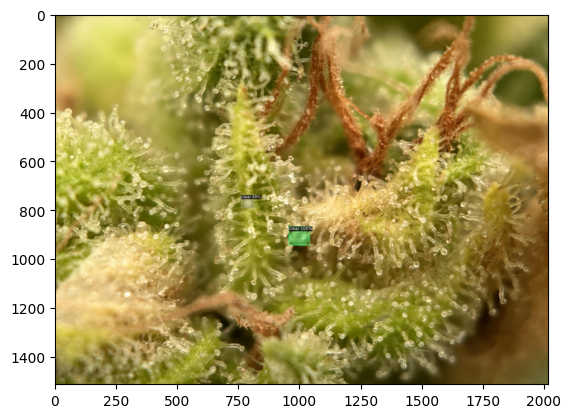

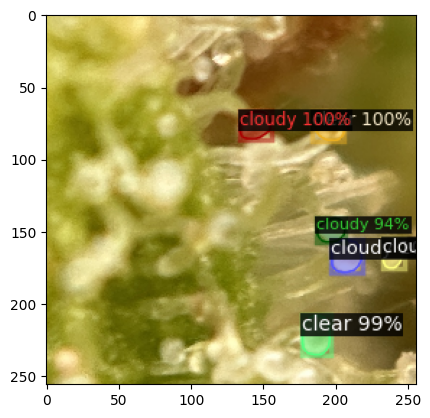

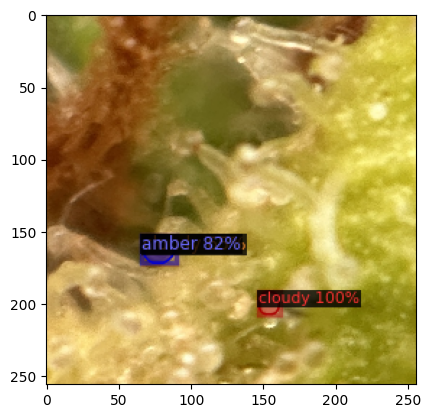

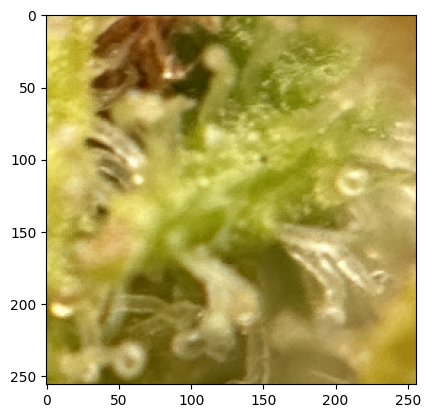

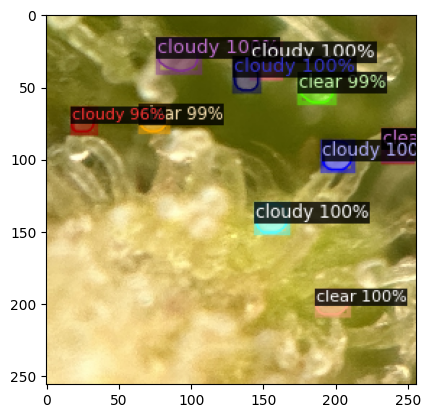

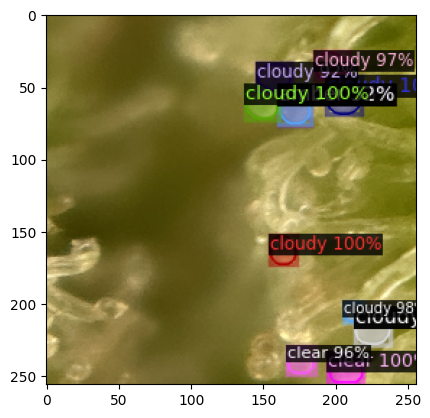

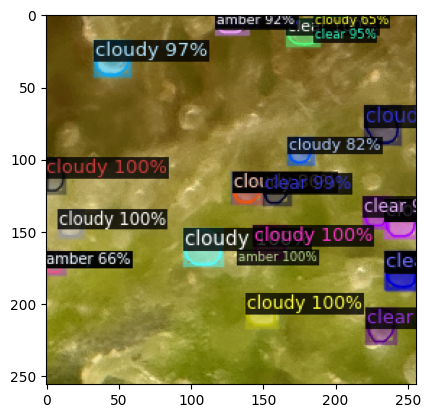

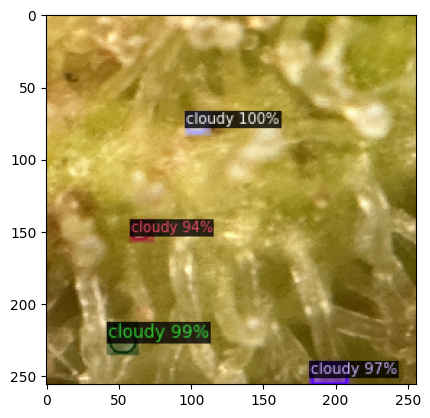

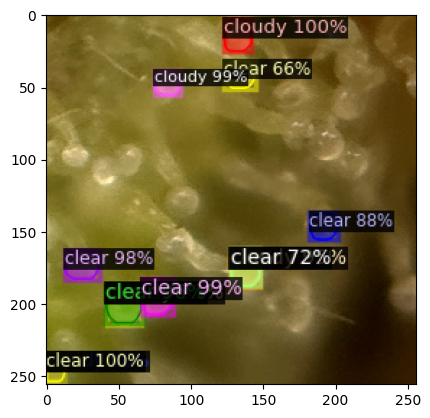

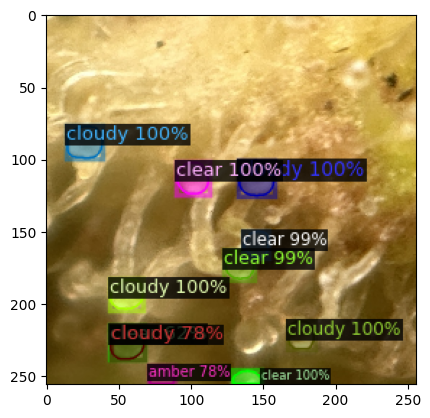

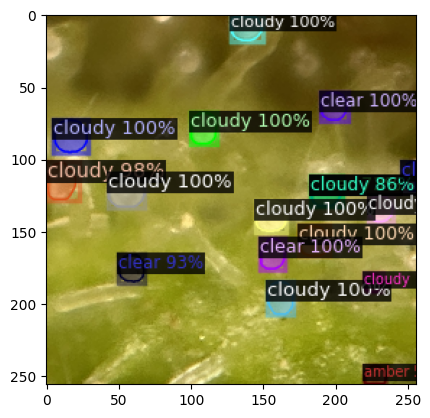

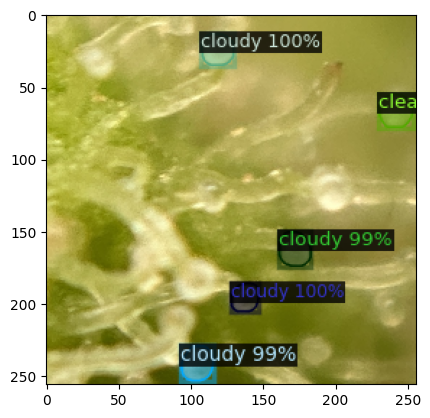

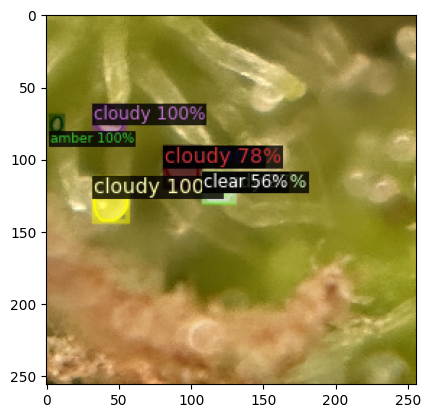

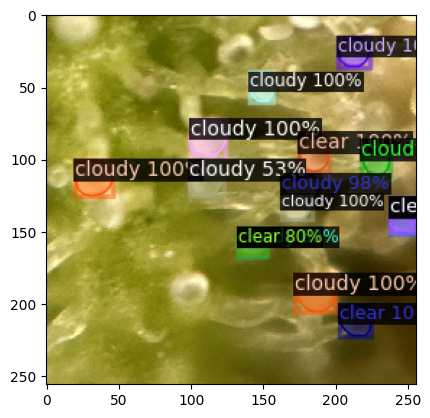

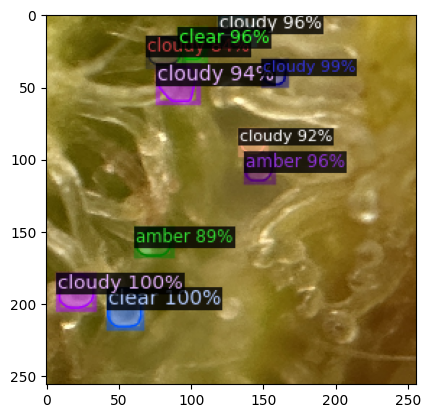

In [8]:
from src.segmentation.framework_handlers.detectron2_handler import plot_test_predictions

plot_test_predictions(dataset_dicts_test, metadata_test, predictor)

In [ ]:
# TODO: encapsulate the statistics calculations for the predictions to a function
# TODO:start saving evaluation results and compare with different models and hyper params

#### Segment images and save object level information into a csv file.



In [11]:
from src.segmentation.framework_handlers.detectron2_handler import extract_object_info_to_csv

dataset_directory = "/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_week8_07_06_2023_3x_regular_IMG_1753" 
input_images_directory = os.path.join(dataset_directory, "v0.1")
csv_file_name = "detected_objects.csv"
output_csv_path = os.path.join(dataset_directory,csv_file_name)

extract_object_info_to_csv(input_images_directory, output_csv_path, predictor, metadata_train)

'Object-level information saved to CSV file at /home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_week8_07_06_2023_3x_regular_IMG_1753/detected_objects.csv'

In [ ]:
from src.segmentation.framework_handlers.detectron2_handler import plot_class_statistics

plot_class_statistics(output_csv_path, metadata_train)

/tmp/ipykernel_24632/3811209441.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Class Name", y="Object Number", data=avg_objects_per_class, ci=None, order=class_names)


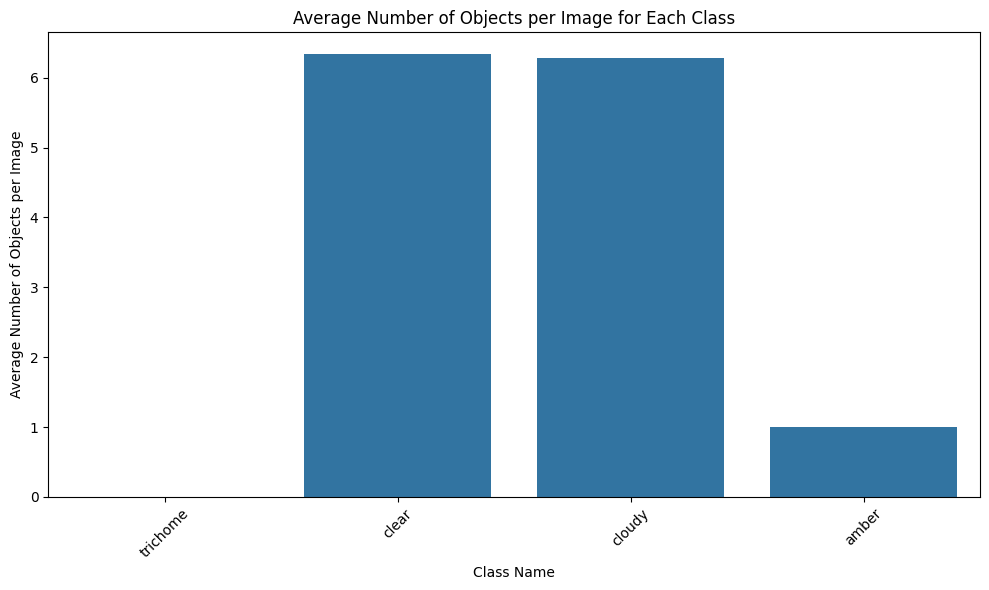

/tmp/ipykernel_24632/3811209441.py:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Class Name", y="Area", data=avg_area_per_class, ci=None, order=class_names)


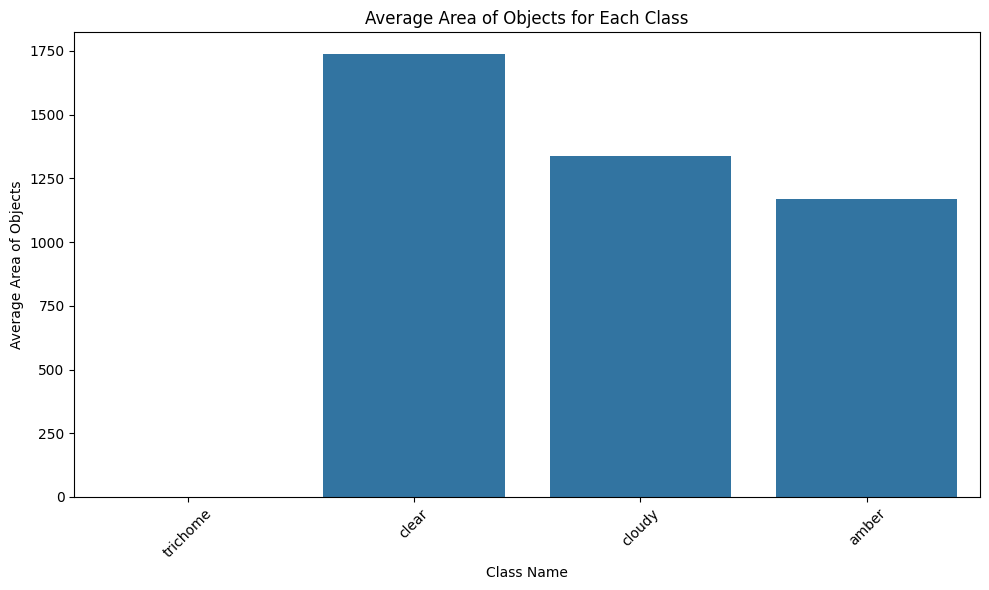

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(output_csv_path)

# Get class names from train_metadata.thing_classes
class_names = metadata_train.thing_classes

# Group the data by both "File Name" and "Class Name" and calculate the average number of objects per image for each class
# first group the data by both "File Name" and "Class Name" and count the number of objects within each group.
#Then, group the data by "Class Name" only and calculate the mean of the counts, which gives us the average number of objects per image for each class.
avg_objects_per_class = df.groupby(["File Name", "Class Name"])["Object Number"].count().reset_index()
avg_objects_per_class = avg_objects_per_class.groupby("Class Name")["Object Number"].mean().reset_index()

# Plot: Average number of objects per image for each class
plt.figure(figsize=(10, 6))
sns.barplot(x="Class Name", y="Object Number", data=avg_objects_per_class, ci=None, order=class_names)
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Average Number of Objects per Image")
plt.title("Average Number of Objects per Image for Each Class")
plt.tight_layout()
plt.show()


# Group the data by class and calculate the average area of objects for each class
avg_area_per_class = df.groupby("Class Name")["Area"].mean().reset_index()

# Plot: Average area of objects for each class
plt.figure(figsize=(10, 6))
sns.barplot(x="Class Name", y="Area", data=avg_area_per_class, ci=None, order=class_names)
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Average Area of Objects")
plt.title("Average Area of Objects for Each Class")
plt.tight_layout()
plt.show()
